In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tables as tb
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
# from tqdm.notebook import tqdm, trange
from tqdm import tqdm

In [2]:
from lmfit import Model, create_params
from lmfit.models import GaussianModel

mod = GaussianModel()

In [3]:
from scipy.special import erf


def damp_osci(x, x0, oa, rg, ro, phase, sigma, w):
    damp = oa * np.exp(-(x-x0)/rg)*np.cos((x-x0)/ro-phase)
    err_func = -0.5 * (erf(-1/np.sqrt(2)*(x-x0)/sigma - sigma/w) ) + 0.5
    return damp * err_func


def exp_decay(x, Amplitude, x0, sigma, w, oa, rg, ro, phase):
    fit1 = Amplitude/2*np.exp(-(x-x0)/w + ((sigma/w)**2)/2)*(1-erf(-1/np.sqrt(2)*(x-x0)/sigma - sigma/w))
    osc = damp_osci(x, x0, oa, rg, ro, phase, sigma, w)
    return fit1 + osc


def gaussian(x, Amplitude, x0, sigma):
    return Amplitude * np.exp(-np.power(x - x0, 2.) / (2 * np.power(sigma, 2.)))


gmodel = Model(exp_decay)

In [4]:
print(f'parameter names: {gmodel.param_names}')
print(f'independent variables: {gmodel.independent_vars}')

parameter names: ['Amplitude', 'x0', 'sigma', 'w', 'oa', 'rg', 'ro', 'phase']
independent variables: ['x']


In [5]:
params = gmodel.make_params(
    Amplitude=dict(value=0.06), 
    x0=dict(value=0.0), 
    sigma=dict(value=0.1), 
    w=dict(value=0.1), 
    oa=dict(value=0, vary=False),
    rg=dict(value=10, vary=False), 
    ro=dict(value=10, vary=False), 
    phase=dict(value=0, vary=False)
)
params

name,value,initial value,min,max,vary
Amplitude,0.06000000,0.06,-inf,inf,True
x0,0.00000000,0.0,-inf,inf,True
sigma,0.10000000,0.1,-inf,inf,True
w,0.10000000,0.1,-inf,inf,True
oa,0.00000000,0,-inf,inf,False
rg,10.0000000,10,-inf,inf,False
ro,10.0000000,10,-inf,inf,False
phase,0.00000000,0,-inf,inf,False


In [6]:
dataset_for_intensity = {}
dataset_for_peak_shift = {}

In [7]:
time_drifts = {}

In [8]:
plt.close('all')

# Jungfrau ROI1 signal

In [24]:
run_n = 224
exp_id = 'ue_240607_FXS'
run_dir = f'/xfel/ffs/dat/{exp_id}/raw_data/h5/type=measurement/run={run_n:03}'
scan_dirs = [scan_dir for scan_dir in sorted(os.listdir(run_dir)) if scan_dir.startswith('scan=')]
scan_numbers = [int(scan_dir.replace('scan=', '')) for scan_dir in scan_dirs]
problem_scans = []
for scan_dir in tqdm(scan_dirs):
    scan_n = int(scan_dir.replace('scan=', ''))
    fnames = [os.path.join(run_dir, scan_dir, fname) for fname in sorted(os.listdir(os.path.join(run_dir, scan_dir)))]
    labels = dict(
        position_label = '',
        pump_event_label = 'event_info.RATE_HX_30HZ',
        # signal_label = 'pd:es:pd1:ch2',
        signal_label = 'detector:eh1:jungfrau2:ROI1_stat.sum',
        # signal_label = 'detector:eh1:jungfrau2:ROI2_stat.sum',
        # norm_label = 'pd:es:pd1:ch
        # norm_label = 'qbpm:oh:qbpm2:sum',
        norm_label = 'qbpm:eh1:qbpm1:sum',
        # norm_label = 'qbpm:eh1:qbpm2:sum',
        # norm_label = 'detector:eh1:jungfrau2:ROI2_stat.sum',
        
        # orm2_label = 'detector:eh1:jungfrau2:ROI7_stat.sum',
      # newsignal_label = 'detector:eh1:jungfrau2:ROI1_stat.sum'
    )
    
    positions = []
    signals_on = []
    signals_off = []
    ps_on = []
    ps_off = []
    sample_no_on = []
    sample_no_off = []
    norms_on = []
    norms_off = []
    signals_o_on = []
    signals_o_off = []
 
    for fname in tqdm(fnames[:], leave=True):
        df = pd.read_hdf(fname)
        if 'delay_input' in df.columns.values:
            labels['position_label'] = 'delay_input'
        elif 'laser_v_input' in df.columns.values:
            labels['position_label'] = 'laser_v_input'
        elif 'laser_h_input' in df.columns.values:
            labels['position_label'] = 'laser_h_input'
        elif 'th_input' in df.columns.values:
            labels['position_label'] = 'th_input'
        elif 'laser_fluence_percent_input' in df.columns.values:
            labels['position_label'] = 'laser_fluence_percent_input'
        elif 'phi_input' in df.columns.values:
            labels['position_label'] = 'phi_input'
        elif 'energy_input' in df.columns.values:
            labels['position_label'] = 'energy_input'
        elif 'dummy_input' in df.columns.values:
            labels['position_label'] = 'dummy_input'
        
        try:
            df_mini = df[labels.values()].dropna()
        except:
            psn = int(scan_dir.split('=')[1])
            problem_scans.append(psn)
            print('There was an error while reading scan=' + str(psn))
            continue
            
        position = df_mini[labels['position_label']].median()
        pump_event = df_mini[labels['pump_event_label']] == True
        
        #bkg_mean = (df_mini[labels['bkg_label']] - df_mini[labels['signal_label']]) / (df_mini[labels['roi2_area_label']] - df_mini[labels['roi1_area_label']])
        roi_sum = (
            df_mini[[
                labels['signal_label'],
            ]].values
            ).sum(axis=1)
        
        norm = df_mini[labels['norm_label']] #- bkg_mean*df_mini[labels['roi3_area_label']]

        norm_mask = np.logical_and(
            norm > norm.mean() - norm.std()*2,
            norm < norm.mean() + norm.std()*2,
        )
        norm_on = norm[norm_mask][pump_event[norm_mask]]
        norm_off = norm[norm_mask][pump_event[norm_mask] != True]
          
        signal_on = roi_sum[norm_mask][pump_event[norm_mask]] #- bkg_mean[pump_event] * df_mini[labels['roi1_area_label']][pump_event]
        signal_off = roi_sum[norm_mask][pump_event[norm_mask] != True] #- bkg_mean[pump_event != True] * df_mini[labels['roi1_area_label']][pump_event !=True]
               
        signal_ratio_on = signal_on / norm_on
        signal_ratio_off = signal_off / norm_off

        
        valid_on = np.logical_and(
            signal_ratio_on<signal_ratio_on.median() + signal_ratio_on.std()*.3, 
            signal_ratio_on>signal_ratio_on.median() - signal_ratio_on.std()*.3
            )
        valid_off = np.logical_and(
            signal_ratio_off<signal_ratio_off.median() + signal_ratio_off.std()*.3, 
            signal_ratio_off>signal_ratio_off.median() - signal_ratio_off.std()*.3
            )

        try:
            p_on = np.polyfit(norm_off, signal_off, 1)
            p_off = np.polyfit(norm_on, signal_on, 1)
        except:
            print('There was an error while reading p_on or p_off, ' + scan_dir)
            continue
        
    
        signal_norm_on = np.average(
            signal_on[valid_on] / norm_on[valid_on],
            weights = norm_on[valid_on]
            )
        signal_norm_off = np.average(
            signal_off[valid_off] / norm_off[valid_off],
            weights = norm_off[valid_off]
            )

        positions.append(position)
        signals_on.append(signal_norm_on)
        signals_off.append(signal_norm_off)
        #ps_on.append(p_on)
        #ps_off.append(p_off)
        sample_no_on.append(valid_on.size)
        sample_no_off.append(valid_off.size)

        signals_o_on.append(np.average(signal_on[valid_on]))
        signals_o_off.append(np.average(signal_off[valid_off]))
        norms_on.append(np.average(norm_on[valid_on]))
        norms_off.append(np.average(norm_off[valid_off]))
        
        
    positions = np.array(positions)
    signals_on = np.array(signals_on)
    signals_off = np.array(signals_off)
    signals_diff = (signals_on - signals_off)/signals_off
    #ps_on = np.array(ps_on)
    #ps_off = np.array(ps_off)
    signals_o_on = np.array(signals_o_on)
    signals_o_off = np.array(signals_o_off)
    norms_on = np.array(norms_on)
    norms_off = np.array(norms_off)
    
    dataset_for_intensity[(run_n, scan_n)] = \
        {
            "labels": labels,
            "positions": positions,
            "signals_on": signals_on,
            "signals_off": signals_off,
            "signals_diff": signals_diff,
            "ps_on": ps_on,
            "ps_off": ps_off, 
            "sample_size_on": np.array(sample_no_on),
            "sample_size_off": np.array(sample_no_off),
        }


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


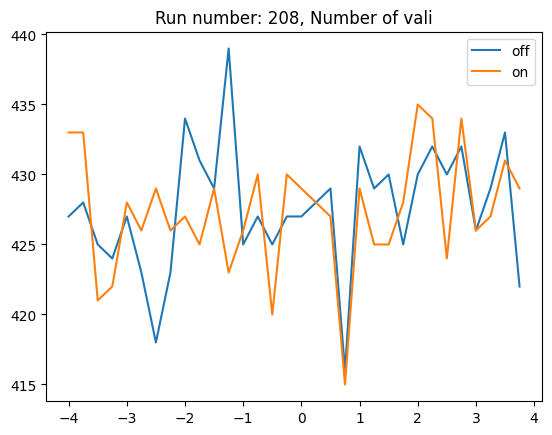

In [11]:
plt.figure()
plt.title(f"Run number: {run_n:}, Number of vali")
plt.plot(dataset_for_intensity[(run_n, scan_n)]["positions"], dataset_for_intensity[(run_n, scan_n)]["sample_size_off"], label = 'off')
plt.plot(dataset_for_intensity[(run_n, scan_n)]["positions"], dataset_for_intensity[(run_n, scan_n)]["sample_size_on"], label = 'on')
plt.legend()
plt.show()

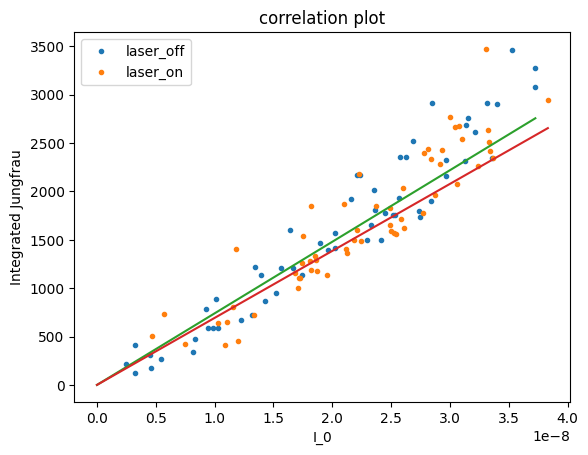

In [25]:
plt.figure(1)
plt.plot(norm_off, signal_off, '.')
plt.plot(norm_on, signal_on, '.')
plt.plot([0, norm_off.max()], signal_norm_off * np.array([0, norm_off.max()]))
plt.plot([0, norm_on.max()], signal_norm_on * np.array([0, norm_on.max()]))
plt.legend(['laser_off', 'laser_on']);
# plt.ylim([-500,4000])
#plt.xlabel('I_qbpm1');
#plt.ylabel('I_signal');
plt.title('correlation plot');
plt.xlabel('I_0')
plt.ylabel('Integrated Jungfrau')
plt.show()

#np.savetxt(f"run ={run_n}", np.array([positions, newsignals_diff]), delimiter=",")
#np.savetxt(f"run ={run_n}", np.array([positions,  signals_off, signals_on]), delimiter=",")

In [26]:
run_n = 224
scan_n = 1
exp_id = 'ue_240607_FXS'
run_dir = f'/xfel/ffs/dat/{exp_id}/raw_data/h5/type=measurement/run={run_n:03}'
scan_dirs = [scan_dir for scan_dir in sorted(os.listdir(run_dir)) if scan_dir.startswith('scan=')]
scan_numbers = [int(scan_dir.replace('scan=', '')) for scan_dir in scan_dirs]

for scan_dir in tqdm(scan_dirs):
    scan_n = int(scan_dir.replace('scan=', ''))
    fnames = [os.path.join(run_dir, scan_dir, fname) for fname in sorted(os.listdir(os.path.join(run_dir, scan_dir)))]

    labels = dict(
        position_label = 'laser_h_input',
        pump_event_label = 'event_info.RATE_HX_30HZ',
        signal_x_label = 'detector:eh1:jungfrau2:ROI1_stat.center_of_mass.x',
        # signal_x_label = 'detector:eh1:jungfrau2:ROI3_stat.center_of_mass.x',
        signal_y_label = 'detector:eh1:jungfrau2:ROI1_stat.center_of_mass.y',
        # signal_y_label = 'detector:eh1:jungfrau2:ROI3_stat.center_of_mass.y',
        # roi1_area_label = 'detector:eh1:jungfrau2:ROI2_stat.area',
        norm_label = 'qbpm:eh1:qbpm1:sum',
        # norm_label = 'qbpm:oh:qbpm2:sum',
    )

    positions = [];    signals_x_on = [];    signals_x_off = [];    signals_y_on = [];    signals_y_off = [];
    for fname in tqdm(fnames, leave=False):
        df = pd.read_hdf(fname)
        if 'delay_input' in df.columns.values:
            labels['position_label'] = 'delay_input'
        elif 'laser_v_input' in df.columns.values:
            labels['position_label'] = 'laser_v_input'
        elif 'laser_h_input' in df.columns.values:
            labels['position_label'] = 'laser_h_input'
        elif 'th_input' in df.columns.values:
            labels['position_label'] = 'th_input'
        elif 'laser_fluence_percent_input' in df.columns.values:
            labels['position_label'] = 'laser_fluence_percent_input'
        
        df_mini = df[labels.values()].dropna()
        position = df_mini[labels['position_label']].median()
        pump_event = df_mini[labels['pump_event_label']] == True
        COMx = df_mini[labels['signal_x_label']]
        COMy = df_mini[labels['signal_y_label']] # + 1000
        norm = df_mini[labels['norm_label']]

        norm_on = norm[pump_event] ;        norm_off = norm[pump_event != True]
        signal_x_on = COMx[pump_event] # - bkg_mean[pump_event] * df_mini[labels['roi1_area_label']][pump_event]
        signal_x_off = COMx[pump_event != True] # - bkg_mean[pump_event != True] * df_mini[labels['roi1_area_label']][pump_event !=True]
        signal_y_on = COMy[pump_event] # - bkg_mean[pump_event] * df_mini[labels['roi1_area_label']][pump_event]
        signal_y_off = COMy[pump_event != True] # - bkg_mean[pump_event != True] * df_mini[labels['roi1_area_label']][pump_event !=True]

        signal_x_norm_on = np.average(
            signal_x_on ,#/ norm_on,
            weights = norm_on        )
        signal_x_norm_off = np.average(
            signal_x_off ,#/ norm_off,
            weights = norm_off        )
        signal_y_norm_on = np.average(
            signal_y_on ,#/ norm_on,
            weights = norm_on        )
        signal_y_norm_off = np.average(
            signal_y_off ,#/ norm_off,
            weights = norm_off        )

        positions.append(position)
        signals_x_on.append(signal_x_norm_on);        signals_x_off.append(signal_x_norm_off);        signals_y_on.append(signal_y_norm_on);        signals_y_off.append(signal_y_norm_off)

    positions = np.array(positions);    signals_x_on = np.array(signals_x_on);    signals_x_off = np.array(signals_x_off)
    signals_y_on = np.array(signals_y_on);    signals_y_off = np.array(signals_y_off)
    signals_x_diff = (signals_x_off - signals_x_on);    signals_y_diff = (signals_y_off - signals_y_on)

    dataset_for_peak_shift[(run_n, scan_n)] = {
        "labels": labels,        "positions": positions,        "signals_x_on": signals_x_on,        "signals_x_off": signals_x_off,        "signals_x_diff": signals_x_diff,
        "signals_y_on": signals_y_on,        "signals_y_off": signals_y_off,        "signals_y_diff": signals_y_diff,
    }
    

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


In [30]:
list(dataset_for_intensity.keys())

[(208, 1), (224, 1)]

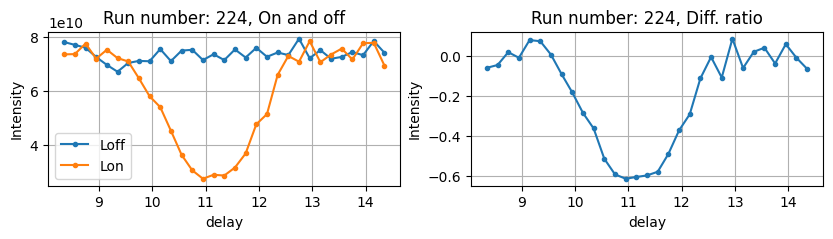

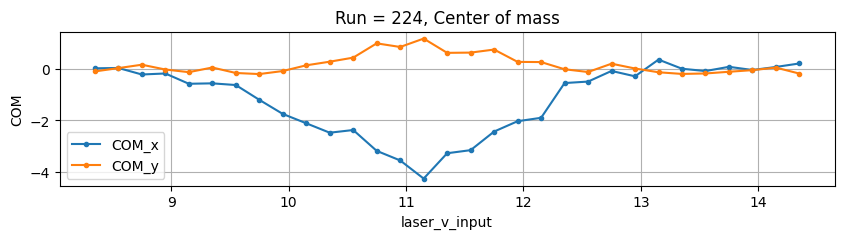

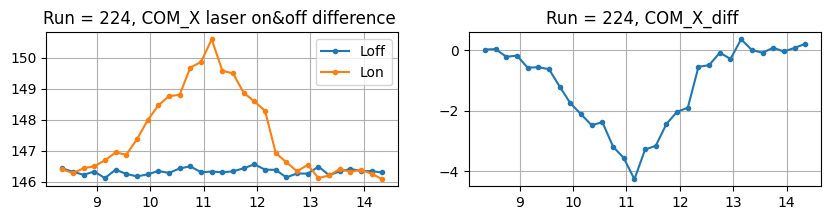

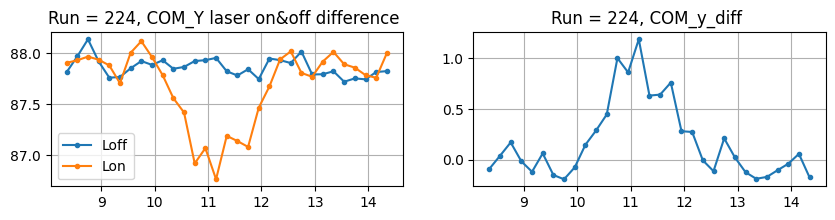

In [31]:
plt.figure(20,figsize=(10,2))
plt.subplot(1,2, 1)
plt.title(f"Run number: {run_n:}, On and off")
plt.plot(dataset_for_intensity[(run_n, scan_n)]["positions"], dataset_for_intensity[(run_n, scan_n)]["signals_off"], '.-')
plt.plot(dataset_for_intensity[(run_n, scan_n)]["positions"], dataset_for_intensity[(run_n, scan_n)]["signals_on"], '.-')
#plt.xlim([8,15])
plt.legend(['Loff', 'Lon']);plt.grid();plt.ylabel('Intensity');plt.xlabel('delay')
plt.subplot(1,2, 2)
plt.title(f"Run number: {run_n:}, Diff. ratio")
plt.plot(dataset_for_intensity[(run_n, scan_n)]["positions"], dataset_for_intensity[(run_n, scan_n)]["signals_diff"], '.-')
plt.grid();plt.ylabel('Intensity');plt.xlabel('delay')

plt.figure(6,figsize=(10,2))
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"], '.-')
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"], '.-')
plt.xlabel(labels['position_label'])
plt.ylabel('COM')
plt.legend(['COM_x','COM_y'])
plt.title(f'Run = {run_n}, Center of mass')
plt.grid()

plt.figure(7,figsize=(10,2))
plt.subplot(1, 2, 1)
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_off"], '.-')
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_on"], '.-')
plt.title(f'Run = {run_n}, COM_X laser on&off difference ')
plt.legend(['Loff', 'Lon'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"], '.-')
plt.title(f'Run = {run_n}, COM_X_diff ')
plt.grid()

plt.figure(8,figsize=(10,2))
plt.subplot(1, 2, 1)
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_off"], '.-')
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_on"], '.-')
plt.title(f'Run = {run_n}, COM_Y laser on&off difference ')
plt.legend(['Loff', 'Lon'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"], '.-')
plt.title(f'Run = {run_n}, COM_y_diff ')
plt.grid()

In [ ]:
run_n

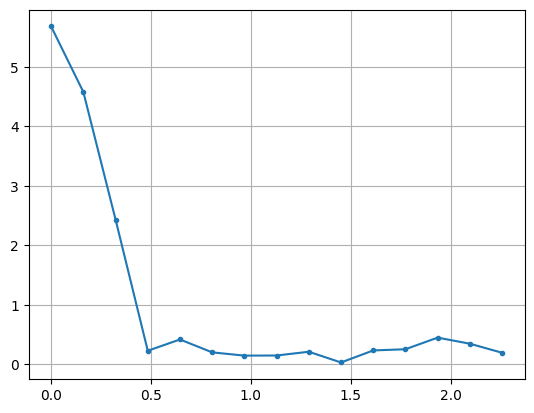

In [32]:
x=dataset_for_intensity[(run_n, scan_n)]["positions"]
y=dataset_for_intensity[(run_n, scan_n)]["signals_diff"]
t0=-1
N=x[x>t0].shape[0]
T=x[1]-x[0]
yf=np.fft.fft(y[x>t0])
xf=np.fft.fftfreq(N,T)[:N//2]
plt.plot(xf,np.abs(yf[0:N//2]),'.-')
plt.grid()

KeyError: (206, 1)

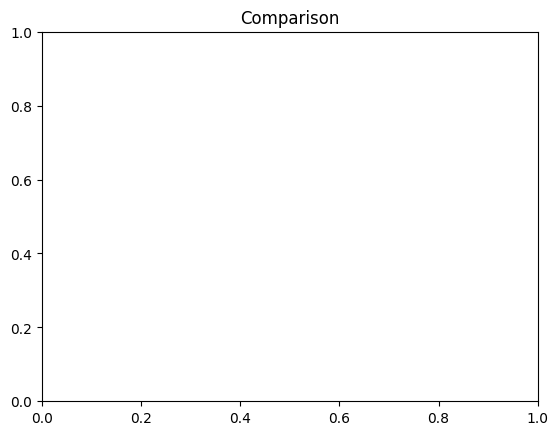

In [33]:
run_ns = [206,207]

plt.figure(25)
plt.title(f"Comparison")
for i,run_n0 in enumerate(run_ns):
    plt.plot(dataset_for_intensity[(run_n0, scan_n)]["positions"], dataset_for_intensity[(run_n0, scan_n)]["signals_on"], label = run_n0)
# plt.xticks(np.arange(-5, 30, step=2))
# plt.xlim([-5,10])
plt.grid()
plt.legend()
plt.show()

In [ ]:
run_ns = [206,207,208,209,210,211]

plt.figure(25)
plt.title(f"Comparison")
for i,run_n0 in enumerate(run_ns):
    plt.plot(dataset_for_peak_shift[(run_n0, scan_n)]["positions"], dataset_for_peak_shift[(run_n0, scan_n)]["signals_x_diff"],'.-')
plt.xlim([-15,15])
plt.ylim([-1,0.2])
plt.grid()
plt.legend()
plt.show()

In [ ]:
run_ns = [107,108,109,110,111]
fluences = [40,10,20,3,30]
mode0_4 = np.zeros(len(run_ns))
plt.figure(21)
plt.title("FFT")
for i,run_n0 in enumerate(run_ns):
    fft_data = dataset_for_intensity[(run_n0, scan_n)]["signals_on"][50:150]
    fft = np.fft.fft(fft_data)
    fft_show = np.sqrt(np.real(fft)**2+np.imag(fft)**2)
    fft_freq = np.arange(0,fft_data.shape[-1],1/10)
    plt.plot(fft_freq[2:30],fft_show[2:30], label = run_n0)
    mode0_4[i] = fft_show[4]

#plt.plot(fft_freq2[4:50],fft_show2[4:50], label = 'second half')
plt.legend()

# Center of Mass

In [15]:
run_n = 224

exp_id = 'ue_240607_FXS'
run_dir = f'/xfel/ffs/dat/{exp_id}/raw_data/h5/type=measurement/run={run_n:03}'
scan_dirs = [scan_dir for scan_dir in sorted(os.listdir(run_dir)) if scan_dir.startswith('scan=')]
scan_numbers = [int(scan_dir.replace('scan=', '')) for scan_dir in scan_dirs]

for scan_dir in tqdm(scan_dirs):
    scan_n = int(scan_dir.replace('scan=', ''))
    fnames = [os.path.join(run_dir, scan_dir, fname) for fname in sorted(os.listdir(os.path.join(run_dir, scan_dir)))]

    labels = dict(
        position_label = 'laser_h_input',
        pump_event_label = 'event_info.RATE_HX_30HZ',
        signal_x_label = 'detector:eh1:jungfrau2:ROI1_stat.center_of_mass.x',
        #signal_x_label = 'detector:eh1:jungfrau2:ROI3_stat.center_of_mass.x',
        signal_y_label = 'detector:eh1:jungfrau2:ROI1_stat.center_of_mass.y',
        #signal_y_label = 'detector:eh1:jungfrau2:ROI3_stat.center_of_mass.y',
        #roi1_area_label = 'detector:eh1:jungfrau2:ROI2_stat.area',
        norm_label = 'qbpm:eh1:qbpm1:sum',
        #norm_label = 'qbpm:oh:qbpm2:sum',
    )

    positions = [];    signals_x_on = [];    signals_x_off = [];    signals_y_on = [];    signals_y_off = [];
    for fname in tqdm(fnames, leave=False):
        df = pd.read_hdf(fname)
        if 'delay_input' in df.columns.values:
            labels['position_label'] = 'delay_input'
        elif 'laser_v_input' in df.columns.values:
            labels['position_label'] = 'laser_v_input'
        elif 'laser_h_input' in df.columns.values:
            labels['position_label'] = 'laser_h_input'
        elif 'th_input' in df.columns.values:
            labels['position_label'] = 'th_input'
        elif 'laser_fluence_percent_input' in df.columns.values:
            labels['position_label'] = 'laser_fluence_percent_input'
        
        df_mini = df[labels.values()].dropna()
        position = df_mini[labels['position_label']].median()
        pump_event = df_mini[labels['pump_event_label']] == True
        COMx = df_mini[labels['signal_x_label']] ;        COMy = df_mini[labels['signal_y_label']] #+ 1000
        norm = df_mini[labels['norm_label']]

        norm_on = norm[pump_event] ;        norm_off = norm[pump_event != True]
        signal_x_on = COMx[pump_event] # - bkg_mean[pump_event] * df_mini[labels['roi1_area_label']][pump_event]
        signal_x_off = COMx[pump_event != True] # - bkg_mean[pump_event != True] * df_mini[labels['roi1_area_label']][pump_event !=True]
        signal_y_on = COMy[pump_event] # - bkg_mean[pump_event] * df_mini[labels['roi1_area_label']][pump_event]
        signal_y_off = COMy[pump_event != True] # - bkg_mean[pump_event != True] * df_mini[labels['roi1_area_label']][pump_event !=True]

        signal_x_norm_on = np.average(
            signal_x_on ,#/ norm_on,
            weights = norm_on        )
        signal_x_norm_off = np.average(
            signal_x_off ,#/ norm_off,
            weights = norm_off        )
        signal_y_norm_on = np.average(
            signal_y_on ,#/ norm_on,
            weights = norm_on        )
        signal_y_norm_off = np.average(
            signal_y_off ,#/ norm_off,
            weights = norm_off        )

        positions.append(position)
        signals_x_on.append(signal_x_norm_on);        signals_x_off.append(signal_x_norm_off);        signals_y_on.append(signal_y_norm_on);        signals_y_off.append(signal_y_norm_off)

    positions = np.array(positions);    signals_x_on = np.array(signals_x_on);    signals_x_off = np.array(signals_x_off)
    signals_y_on = np.array(signals_y_on);    signals_y_off = np.array(signals_y_off)
    signals_x_diff = (signals_x_off - signals_x_on);    signals_y_diff = (signals_y_off - signals_y_on)

    dataset_for_peak_shift[(run_n, scan_n)] = {
        "labels": labels,        "positions": positions,        "signals_x_on": signals_x_on,        "signals_x_off": signals_x_off,        "signals_x_diff": signals_x_diff,
        "signals_y_on": signals_y_on,        "signals_y_off": signals_y_off,        "signals_y_diff": signals_y_diff,
    }
    

100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


In [ ]:
plt.figure(6,figsize=(10,2))
for scan_n in scan_numbers:
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"], '.-')
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"], '.-')
plt.xlabel(labels['position_label'])
plt.ylabel('COM')
plt.legend(['COM_x','COM_y'])
plt.title(f'Run = {run_n}, Center of mass')
plt.grid()

plt.figure(7,figsize=(10,2))
plt.subplot(1, 2, 1)
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_off"], '.-')
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_on"], '.-')
plt.title(f'Run = {run_n}, COM_X laser on&off difference ')
plt.legend(['Loff', 'Lon'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"], '.-')
plt.title(f'Run = {run_n}, COM_X_diff ')
plt.grid()

plt.figure(8,figsize=(10,2))
plt.subplot(1, 2, 1)
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_off"], '.-')
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_on"], '.-')
plt.title(f'Run = {run_n}, COM_Y laser on&off difference ')
plt.legend(['Loff', 'Lon'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"], '.-')
plt.title(f'Run = {run_n}, COM_y_diff ')
plt.grid()

In [ ]:
plt.figure(7)
plt.subplot(1, 2, 1)
for run_n in [20]:
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_off"], '.-')
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_on"], '.-')
plt.title(f'Run = {run_n}, COM_X laser on&off difference ')

plt.figure(7)
plt.subplot(1, 2, 2)
for run_n in [20]:
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"], '.-')
plt.title(f'Run = {run_n}, COM_X_diff ')
plt.show()

# laser power check

In [ ]:
plt.figure(82)

for i in range(37,48):
    run_n = i
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"], '.-')
    # plt.axhline(y=0, color='k', linestyle='-')
plt.title(f' COM_X_diff ')
plt.ylabel('Peak shift (pixels)')
plt.xlabel('Delay (ps)')
plt.legend([1,2,3,4,5,6,8,9,10,15,20])
plt.grid()

plt.show()

plt.figure(83)
for i in range(37,48):
    run_n = i
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"], '.-')
    # plt.axhline(y=0, color='k', linestyle='-')
plt.title(f' COM_y_diff ')
plt.ylabel('Peak shift (pixels)')
plt.xlabel('Delay (ps)')
plt.legend([1,2,3,4,5,6,8,9,10,15,20])
plt.grid()
plt.show()

In [ ]:
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"], '.-')

In [ ]:
xdfdata=[];ydfdata=[]
ii=0
jj=11
for i in range(37,48):
    run_n=i
    xdfdata = np.append(xdfdata,dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"][jj])
    ydfdata = np.append(ydfdata,dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"][jj])
    ii+=1
plt.plot([1,2,3,4,5,6,8,9,10,15,20],xdfdata,'.-')
plt.plot([1,2,3,4,5,6,8,9,10,15,20],ydfdata,'.-')
delay=dataset_for_peak_shift[(run_n, scan_n)]["positions"][jj]
plt.title(f'delay at {delay}ps')
plt.xlabel('delay(ps)');plt.ylabel('pixel difference')
plt.grid()
plt.legend(['xdiff','ydiff'])

In [ ]:
plt.figure(82)
for i in range(36,48):
    run_n = i
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"], '.-')
    plt.axhline(y=0, color='k', linestyle='-')
plt.title(f'Run = {run_n}, COM_X_diff ')
plt.ylabel('Peak shift (pixels)')
plt.xlabel('Delay (ps)')
#plt.axis([-1, 15, -2, 0.2])
plt.show()

In [ ]:
plt.figure(82,figsize=(15,5))

plt.subplot(1,2,1)
for i in range(79,93):
    run_n = i
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"], '.-')
    # plt.axhline(y=0, color='k', linestyle='-')
plt.title(f' COM_X_diff ')
plt.ylabel('Peak shift (pixels)')
plt.xlabel('Delay (ps)')
plt.legend([15,16,17,18,19,20,15,14,13,12,11,10,8,6])
plt.grid()

plt.xlim([-20,200]);plt.ylim([-10,3])
# plt.show()

plt.subplot(1,2,2)
for i in range(79,93):
    run_n = i
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"], '.-')
    # plt.axhline(y=0, color='k', linestyle='-')
plt.title(f' COM_Y_diff ')
plt.ylabel('Peak shift (pixels)')
plt.xlabel('Delay (ps)')
plt.legend([15,16,17,18,19,20,15,14,13,12,11,10,8,6])
plt.grid()

plt.xlim([-20,200]);plt.ylim([-10,3])
plt.show()

In [ ]:
plt.figure(82)

for i in [47,79,85]:
    run_n = i
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"], '.-')
    # plt.axhline(y=0, color='k', linestyle='-')
plt.title(f' COM_X_diff ')
plt.ylabel('Peak shift (pixels)')
plt.xlabel('Delay (ps)')
plt.legend([47,79,85])
plt.grid()

plt.show()

for i in [47,79,85]:
    run_n = i
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"], '.-')
    # plt.axhline(y=0, color='k', linestyle='-')
plt.title(f' COM_Y_diff ')
plt.ylabel('Peak shift (pixels)')
plt.xlabel('Delay (ps)')
plt.legend([47,79,85])
plt.grid()

plt.show()


In [ ]:
plt.figure(82,figsize=(15,5))
plt.subplot(1,3,1)
xdfdata=[];ydfdata=[]
ii=0
jj=8
for i in range(79,93):
    run_n=i
    xdfdata = np.append(xdfdata,dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"][jj])
    ydfdata = np.append(ydfdata,dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"][jj])
    ii+=1
plt.plot([15,16,17,18,19,20,15,14,13,12,11,10,8,6],xdfdata,'o')
plt.plot([15,16,17,18,19,20,15,14,13,12,11,10,8,6],ydfdata,'o')
delay=dataset_for_peak_shift[(run_n, scan_n)]["positions"][jj]
plt.title(f'delay at {delay}ps')
plt.xlabel('laser power (%)');plt.ylabel('pixel difference')
plt.grid()
plt.legend(['xdiff','ydiff'])
plt.ylim([-8,2])
xdfdata=[];ydfdata=[]


plt.subplot(1,3,2)
xdfdata=[];ydfdata=[]
ii=0
jj=10
for i in range(79,93):
    run_n=i
    xdfdata = np.append(xdfdata,dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"][jj])
    ydfdata = np.append(ydfdata,dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"][jj])
    ii+=1
plt.plot([15,16,17,18,19,20,15,14,13,12,11,10,8,6],xdfdata,'o')
plt.plot([15,16,17,18,19,20,15,14,13,12,11,10,8,6],ydfdata,'o')
delay=dataset_for_peak_shift[(run_n, scan_n)]["positions"][jj]
plt.title(f'delay at {delay}ps')
plt.xlabel('laser power (%)');plt.ylabel('pixel difference')
plt.grid()
plt.legend(['xdiff','ydiff'])
plt.ylim([-8,2])
xdfdata=[];ydfdata=[]

plt.subplot(1,3,3)
ii=0
jj=12
for i in range(79,93):
    run_n=i
    xdfdata = np.append(xdfdata,dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"][jj])
    ydfdata = np.append(ydfdata,dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"][jj])
    ii+=1
plt.plot([15,16,17,18,19,20,15,14,13,12,11,10,8,6],xdfdata,'o')
plt.plot([15,16,17,18,19,20,15,14,13,12,11,10,8,6],ydfdata,'o')
delay=dataset_for_peak_shift[(run_n, scan_n)]["positions"][jj]
plt.title(f'delay at {delay}ps')
plt.xlabel('laser power (%)');plt.ylabel('pixel difference')
plt.grid()
plt.legend(['xdiff','ydiff'])
plt.ylim([-8,2])

In [ ]:
xdfdata=[];ydfdata=[]
ii=0
jj=9
for i in range(79,91):
    run_n=i
    xdfdata = np.append(xdfdata,dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"][jj])
    ydfdata = np.append(ydfdata,dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"][jj])
    ii+=1
plt.plot([15,16,17,18,19,20,15,14,13,12,11,10],xdfdata,'o')
plt.plot([15,16,17,18,19,20,15,14,13,12,11,10],ydfdata,'o')
delay=dataset_for_peak_shift[(run_n, scan_n)]["positions"][jj]
plt.title(f'delay at {delay}ps')
plt.xlabel('laser power (%)');plt.ylabel('pixel difference')
plt.grid()
plt.legend(['xdiff','ydiff'])
plt.ylim([-8,2])

# spatial overlap check

In [ ]:
run_n = 258

exp_id = 'ue_240607_FXS'
run_dir = f'/xfel/ffs/dat/{exp_id}/raw_data/h5/type=measurement/run={run_n:03}'
scan_dirs = [scan_dir for scan_dir in sorted(os.listdir(run_dir)) if scan_dir.startswith('scan=')]
scan_numbers = [int(scan_dir.replace('scan=', '')) for scan_dir in scan_dirs]

for scan_dir in tqdm(scan_dirs):
    scan_n = int(scan_dir.replace('scan=', ''))
    fnames = [os.path.join(run_dir, scan_dir, fname) for fname in sorted(os.listdir(os.path.join(run_dir, scan_dir)))]

    labels = dict(
        position_label = 'laser_h_input',
        pump_event_label = 'event_info.RATE_HX_30HZ',
        signal_x_label = 'detector:eh1:jungfrau2:ROI1_stat.center_of_mass.x',
        signal_y_label = 'detector:eh1:jungfrau2:ROI1_stat.center_of_mass.y',
        norm_label = 'qbpm:oh:qbpm2:sum',
        # norm_label = 'qbpm:eh1:qbpm1:sum',        
    )

    positions = [];    signals_x_on = [];    signals_x_off = [];    signals_y_on = [];    signals_y_off = [];
    for fname in tqdm(fnames, leave=False):
        df = pd.read_hdf(fname)
        if 'delay_input' in df.columns.values:
            labels['position_label'] = 'delay_input'
        elif 'laser_v_input' in df.columns.values:
            labels['position_label'] = 'laser_v_input'
        elif 'laser_h_input' in df.columns.values:
            labels['position_label'] = 'laser_h_input'
        elif 'laser_fluence_percent_input' in df.columns.values:
            labels['position_label'] = 'laser_fluence_percent_input'
        
        df_mini = df[labels.values()].dropna()
        position = df_mini[labels['position_label']].median()
        pump_event = df_mini[labels['pump_event_label']] == True
        COMx = df_mini[labels['signal_x_label']] ;        COMy = df_mini[labels['signal_y_label']] #+ 1000
        norm = df_mini[labels['norm_label']]

        norm_on = norm[pump_event] ;        norm_off = norm[pump_event != True]
        signal_x_on = COMx[pump_event] ;        signal_x_off = COMx[pump_event != True] # - bkg_mean[pump_event != True] * df_mini[labels['roi1_area_label']][pump_event !=True]
        signal_y_on = COMy[pump_event] ;        signal_y_off = COMy[pump_event != True] # - bkg_mean[pump_event != True] * df_mini[labels['roi1_area_label']][pump_event !=True]

        signal_x_norm_on = np.average(signal_x_on ,#/ norm_on,
            weights = norm_on        )
        signal_x_norm_off = np.average(signal_x_off ,#/ norm_off,
            weights = norm_off        )
        signal_y_norm_on = np.average(signal_y_on ,#/ norm_on,
            weights = norm_on        )
        signal_y_norm_off = np.average(signal_y_off ,#/ norm_off,
            weights = norm_off        )

        positions.append(position);        signals_x_on.append(signal_x_norm_on);        signals_x_off.append(signal_x_norm_off);        signals_y_on.append(signal_y_norm_on);        signals_y_off.append(signal_y_norm_off)
    positions = np.array(positions);    signals_x_on = np.array(signals_x_on);    signals_x_off = np.array(signals_x_off)
    signals_y_on = np.array(signals_y_on);    signals_y_off = np.array(signals_y_off)
    signals_x_diff = (signals_x_off - signals_x_on);    signals_y_diff = (signals_y_off - signals_y_on)
    dataset_for_peak_shift[(run_n, scan_n)] = {
        "labels": labels,        "positions": positions,        "signals_x_on": signals_x_on,        "signals_x_off": signals_x_off,        "signals_x_diff": signals_x_diff,
        "signals_y_on": signals_y_on,        "signals_y_off": signals_y_off,        "signals_y_diff": signals_y_diff,    }

xdata=[];ydata=[]
plt.figure()
xdata=dataset_for_peak_shift[(run_n, scan_n)]["positions"]
ydata= dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"]
plt.plot(xdata,ydata, '.-')
pars=mod.guess(ydata,x=xdata)
yf=mod.fit(ydata,pars,x=xdata)
plt.plot(xdata,yf.best_fit)
plt.grid()
fitfwhm=yf.params['fwhm'].value
fitcenter=yf.params['center'].value
plt.legend([f'fwhm: {fitfwhm} mm', f'cen: {fitcenter},mm'])
plt.title(f'runNum : {run_n}')
# plt.figure(28)
# run_n = 28
# xdata2=dataset_for_peak_shift[(run_n, scan_n)]["positions"]
# ydata2= dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"]

# plt.plot(xdata,ydata, '.-')

In [ ]:
xdata=[];ydata=[]
run_n = 199
plt.figure()
xdata=dataset_for_peak_shift[(run_n, scan_n)]["positions"]
ydata= dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"]
plt.plot(xdata,ydata, 'ko')
pars=mod.guess(ydata,x=xdata)
yf=mod.fit(ydata,pars,x=xdata)
plt.plot(xdata,yf.best_fit,'r')
plt.grid()
fitfwhm=yf.params['fwhm'].value
fitcenter=yf.params['center'].value
# plt.legend([f'fwhm: {fitfwhm} mm', f'cen: {fitcenter},mm'])
# plt.title(f'runNum : {run_n}')
# plt.plot(11.3739,-3,'.')

run_n = 215
xdata=[];ydata=[]

xdata=dataset_for_peak_shift[(run_n, scan_n)]["positions"]
ydata= dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"]
plt.plot(xdata,ydata, 'bo')
pars=mod.guess(ydata,x=xdata)
yf=mod.fit(ydata,pars,x=xdata)
plt.plot(xdata,yf.best_fit,'r')
plt.grid()
fitfwhm=yf.params['fwhm'].value
fitcenter=yf.params['center'].value
# plt.legend([f'fwhm: {fitfwhm} mm', f'cen: {fitcenter},mm'])
# plt.title(f'runNum : {run_n}')
plt.grid()
plt.legend(['run199','','run215'])
plt.title('compare')

In [ ]:
xdata=[];ydata=[]
run_n = 200
plt.figure()
xdata=dataset_for_peak_shift[(run_n, scan_n)]["positions"]
ydata= dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"]
plt.plot(xdata,ydata, 'ko')
pars=mod.guess(ydata,x=xdata)
yf=mod.fit(ydata,pars,x=xdata)
plt.plot(xdata,yf.best_fit,'r')
plt.grid()
fitfwhm=yf.params['fwhm'].value
fitcenter=yf.params['center'].value
# plt.legend([f'fwhm: {fitfwhm} mm', f'cen: {fitcenter},mm'])
plt.title(f'runNum : {run_n}')
# plt.plot(11.3739,-3,'.')

run_n = 216
xdata=[];ydata=[]

xdata=dataset_for_peak_shift[(run_n, scan_n)]["positions"]
ydata= dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"]
plt.plot(xdata,ydata, 'bo')
pars=mod.guess(ydata,x=xdata)
yf=mod.fit(ydata,pars,x=xdata)
plt.plot(xdata,yf.best_fit,'r')
plt.grid()
fitfwhm=yf.params['fwhm'].value
fitcenter=yf.params['center'].value
# plt.legend([f'fwhm: {fitfwhm} mm', f'cen: {fitcenter},mm'])
plt.title(f'runNum : {run_n}')
plt.grid()
plt.legend(['run200','','run216'])

In [ ]:
run_n=224
xdata=[];ydata=[]
params = gmodel.make_params(
    Amplitude=dict(value=0.06), 
    x0=dict(value=0.0), 
    sigma=dict(value=0.1), 
    w=dict(value=0.1), 
    oa=dict(value=0, vary=False),
    rg=dict(value=10, vary=False), 
    ro=dict(value=10, vary=False), 
    phase=dict(value=0, vary=False)
)
params
plt.figure()
gmodel = Model(exp_decay)
xdata=dataset_for_peak_shift[(run_n, scan_n)]["positions"]
ydata=dataset_for_peak_shift[(run_n, scan_n)]["signals_x_on"]

plt.plot(xdata,ydata, '.-')
yf=gmodel.fit(ydata,params,x=xdata)
plt.plot(xdata,yf.best_fit)
plt.grid()
# fitfwhm=yf.params['fwhm'].value
x0=yf.params['x0'].value
plt.legend([f'timezero: {x0}'])
# fitcenter=yf.params['center'].value
# plt.legend([f'fwhm: {fitfwhm} mm', f'cen: {fitcenter}'])

plt.title(f'runNum : {run_n}')
# plt.plot(2.2657,-3,'.')

In [ ]:
yf.params['x0']

In [ ]:
params